In [1]:
import seaborn as sns
import pandas as pd
import math
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier , GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.svm import SVC
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix,roc_curve, roc_auc_score, auc,  ConfusionMatrixDisplay
)
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import RocCurveDisplay
import warnings
warnings.filterwarnings("ignore")

In [2]:
df = pd.read_csv("/content/selected_features.csv")  # Replace with your actual file

In [3]:
X = df.drop(["target" , "degree"], axis=1)      # Replace 'target' with actual column name
y = df["target"]

In [4]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [5]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [6]:
models = {
    "Logistic Regression": {
        "model": LogisticRegression(max_iter=10000),
        "params": {
            "C": [0.1, 1, 10, 100],
            "solver": ["liblinear", "lbfgs"]
        }
    },
    "SVM": {
        "model": SVC(probability=True),
        "params": {
            "C": [0.1, 1, 10],
            "kernel": ["linear", "rbf"]
        }
    },
    "Random Forest": {
        "model": RandomForestClassifier(),
        "params": {
            "n_estimators": [50, 100, 200],
            "max_depth": [None, 5, 10]
        }
    },
    "Gradient Boosting": {
        "model": GradientBoostingClassifier(),
        "params": {
            "n_estimators": [50, 100, 200],
            "learning_rate": [0.01, 0.1, 0.2]
        }
    },
    "KNN": {
        "model": KNeighborsClassifier(),
        "params": {
            "n_neighbors": [3, 5, 7],
            "weights": ["uniform", "distance"]
        }
    },
    "Naive Bayes": {
        "model": GaussianNB(),
        "params": {}  # No hyperparameters to tune
    },
    "XGBoost": {
        "model": XGBClassifier(use_label_encoder=False, eval_metric='logloss'),
        "params": {
            "n_estimators": [50, 100, 200],
            "learning_rate": [0.01, 0.1, 0.2],
            "max_depth": [3, 5, 7]
        }
    }
}

In [7]:
results = {}

# Assume you have X_train, X_test, y_train, y_test defined
for name, m in models.items():
    print(f"\nTraining {name}...")
    clf = GridSearchCV(m["model"], m["params"], cv=5, scoring='roc_auc')
    clf.fit(X_train, y_train)
    best_model = clf.best_estimator_

    y_pred = best_model.predict(X_test)
    y_proba = best_model.predict_proba(X_test)[:, 1]

    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_proba)
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    cm = confusion_matrix(y_test, y_pred)

    results[name] = {
        "model": best_model,
        "auc_score": roc_auc,
        "fpr": fpr,
        "tpr": tpr,
        "conf_matrix": cm
    }

    print(f"\n{name} Evaluation:")
    print(f"Accuracy:  {acc:.4f}")
    print(f"Precision: {prec:.4f}")
    print(f"Recall:    {rec:.4f}")
    print(f"F1 Score:  {f1:.4f}")
    print(f"AUC Score: {roc_auc:.4f}")


Training Logistic Regression...

Logistic Regression Evaluation:
Accuracy:  0.8043
Precision: 0.8319
Recall:    0.8468
F1 Score:  0.8393
AUC Score: 0.8252

Training SVM...

SVM Evaluation:
Accuracy:  0.7989
Precision: 0.8304
Recall:    0.8378
F1 Score:  0.8341
AUC Score: 0.8256

Training Random Forest...

Random Forest Evaluation:
Accuracy:  0.7880
Precision: 0.8333
Recall:    0.8108
F1 Score:  0.8219
AUC Score: 0.8450

Training Gradient Boosting...

Gradient Boosting Evaluation:
Accuracy:  0.7880
Precision: 0.8214
Recall:    0.8288
F1 Score:  0.8251
AUC Score: 0.8432

Training KNN...

KNN Evaluation:
Accuracy:  0.7772
Precision: 0.8241
Recall:    0.8018
F1 Score:  0.8128
AUC Score: 0.8252

Training Naive Bayes...

Naive Bayes Evaluation:
Accuracy:  0.7609
Precision: 0.8190
Recall:    0.7748
F1 Score:  0.7963
AUC Score: 0.8204

Training XGBoost...

XGBoost Evaluation:
Accuracy:  0.7935
Precision: 0.8288
Recall:    0.8288
F1 Score:  0.8288
AUC Score: 0.8443


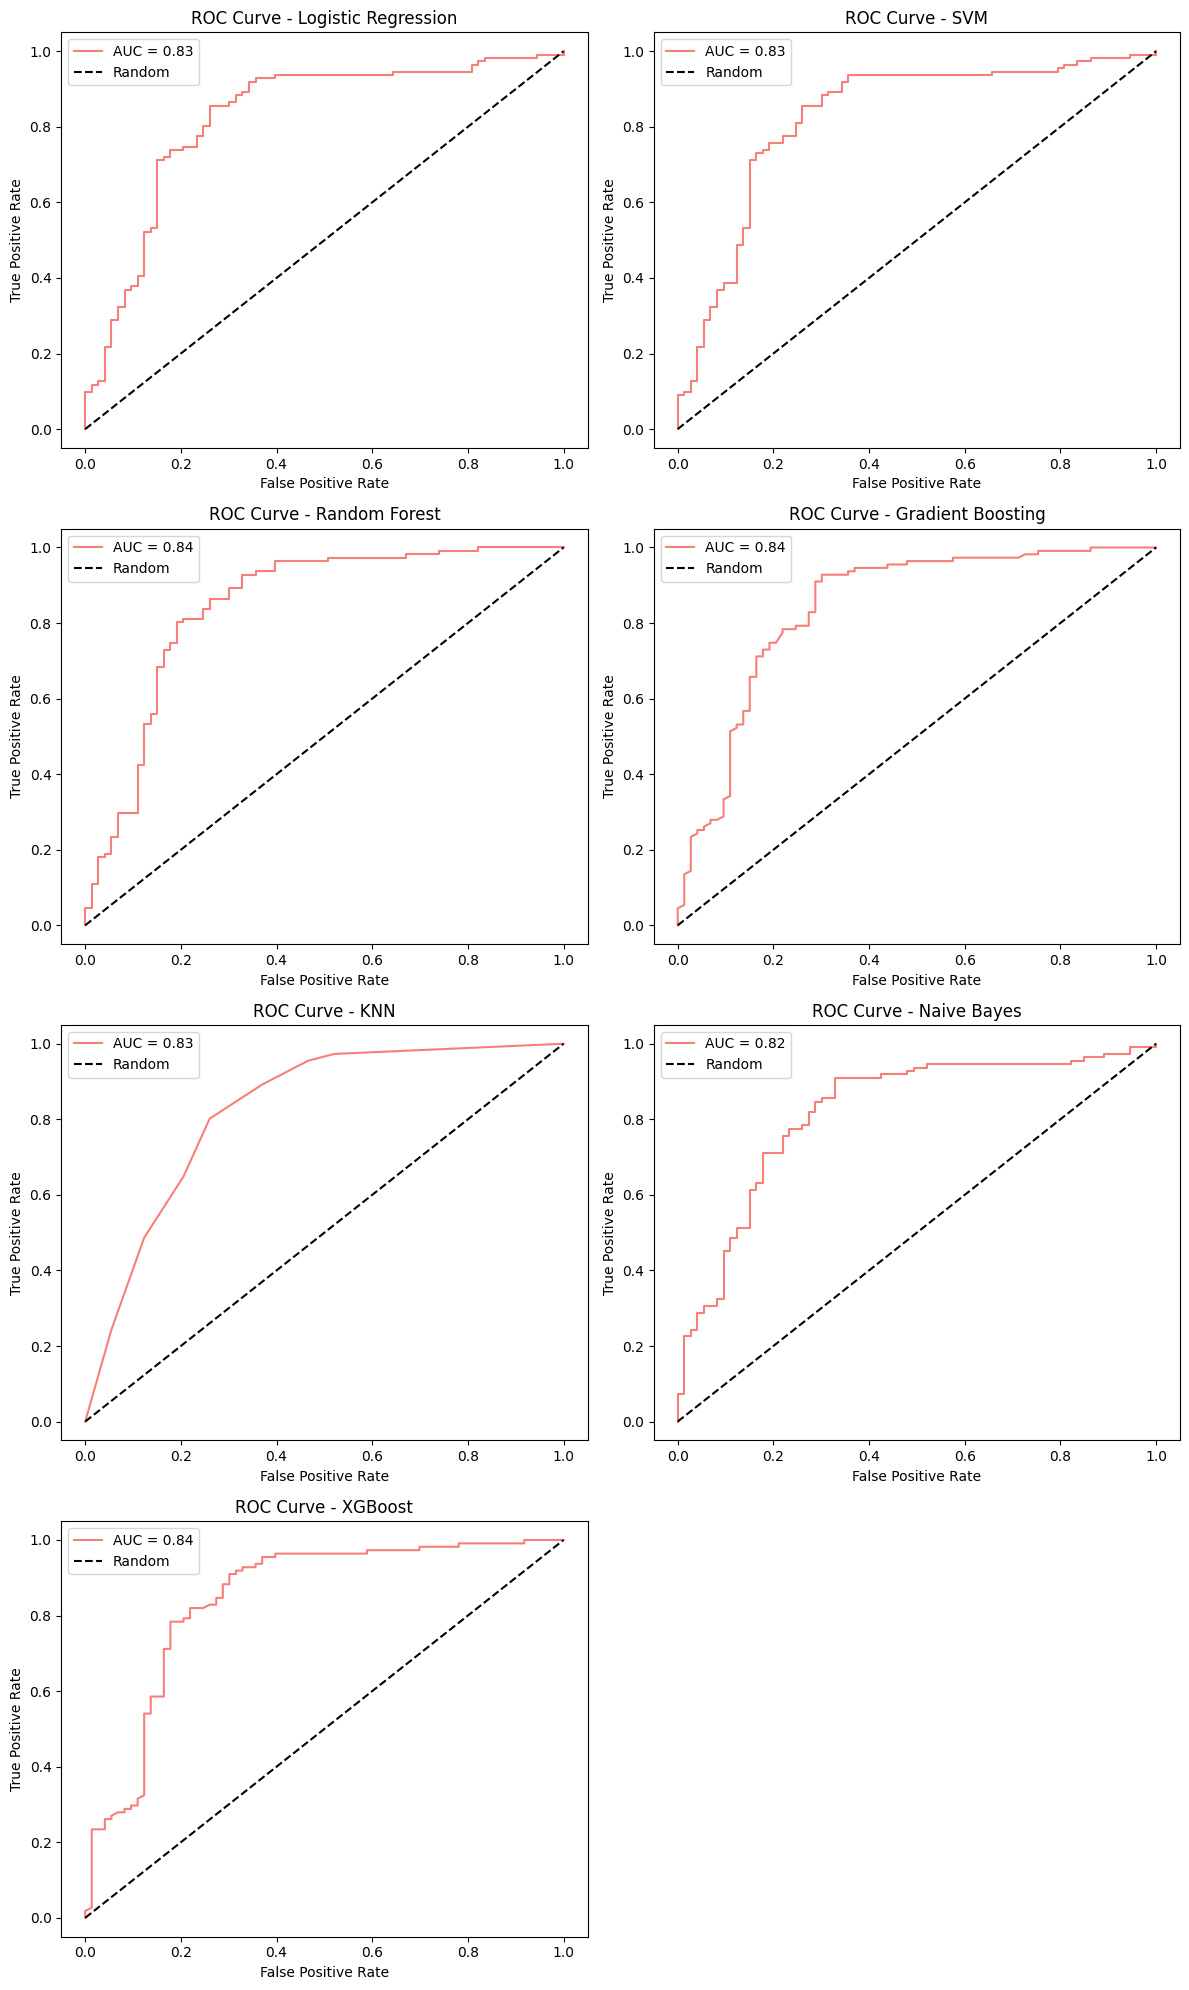

In [8]:
n_models = len(results)
n_cols = 2
n_rows = int(np.ceil(n_models / n_cols))

fig_roc, axes_roc = plt.subplots(n_rows, n_cols, figsize=(6 * n_cols, 5 * n_rows))
axes_roc = axes_roc.flatten()

for i, (name, res) in enumerate(results.items()):
    axes_roc[i].plot(res["fpr"], res["tpr"], label=f"AUC = {res['auc_score']:.2f}" , color = "#f67f79")
    axes_roc[i].plot([0, 1], [0, 1], 'k--', label="Random")
    axes_roc[i].set_title(f"ROC Curve - {name}")
    axes_roc[i].set_xlabel("False Positive Rate")
    axes_roc[i].set_ylabel("True Positive Rate")
    axes_roc[i].legend()

for j in range(i + 1, len(axes_roc)):
    fig_roc.delaxes(axes_roc[j])

plt.tight_layout()
plt.show()


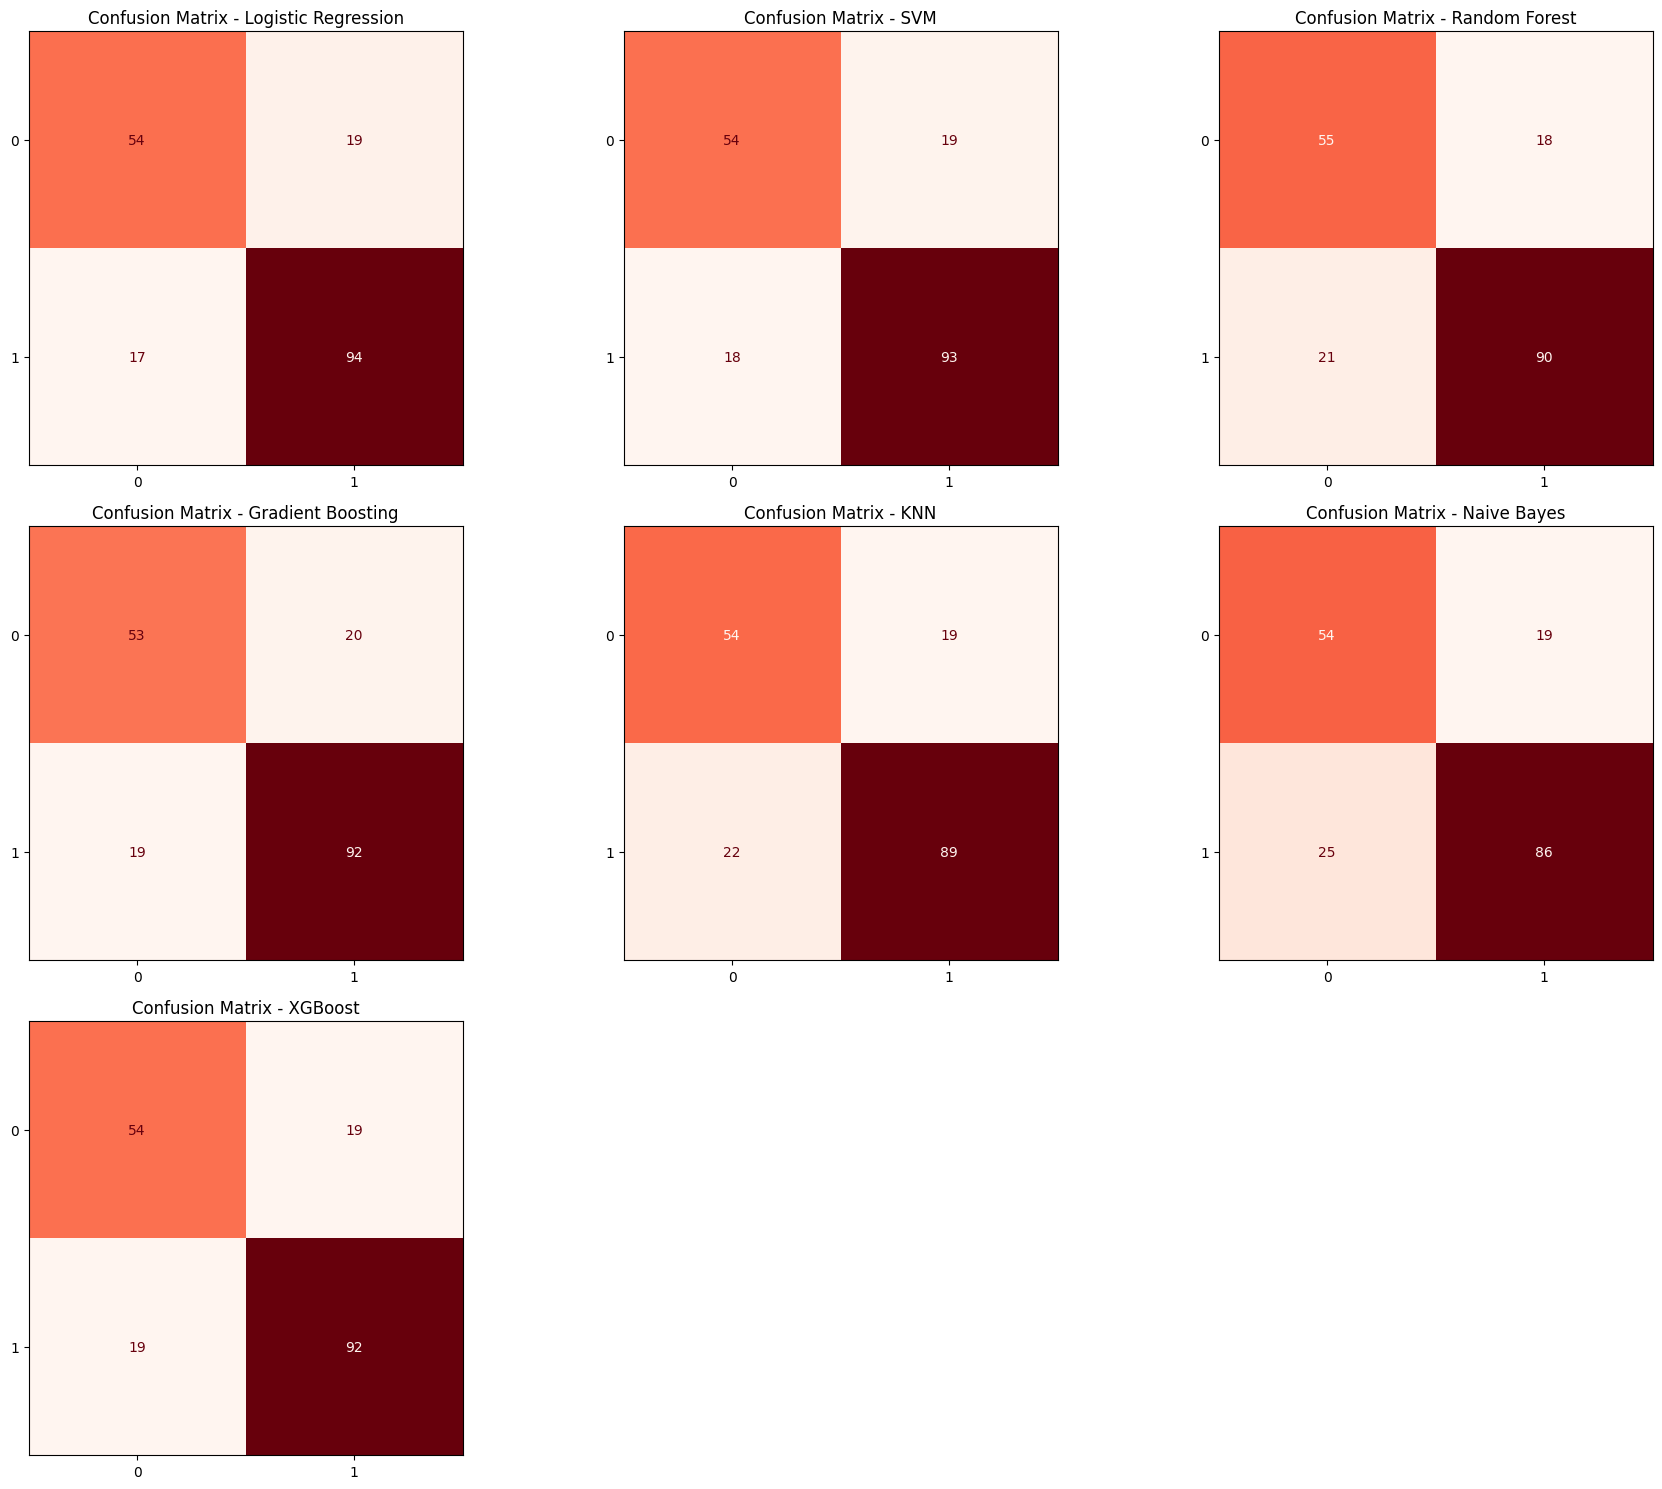

In [9]:
n_models = len(results)
n_cols = 3
n_rows = math.ceil(n_models / n_cols)

fig_cm, axes_cm = plt.subplots(n_rows, n_cols, figsize=(6 * n_cols, 5 * n_rows))
axes_cm = axes_cm.flatten()

for i, (name, res) in enumerate(results.items()):
    cm = res["conf_matrix"]

    # Clear the axis to prevent overlapping
    axes_cm[i].cla()

    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(ax=axes_cm[i], cmap=plt.cm.Reds, values_format='d', colorbar=False)
    axes_cm[i].set_title(f"Confusion Matrix - {name}")

    # Hide axis labels to make layout cleaner (optional)
    axes_cm[i].set_xlabel('')
    axes_cm[i].set_ylabel('')

# Remove any unused subplots
for j in range(i + 1, len(axes_cm)):
    fig_cm.delaxes(axes_cm[j])

plt.tight_layout()
plt.show()
